In [ ]:
!pip install -U fastai
!pip install efficientnet_pytorch

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
from efficientnet_pytorch import EfficientNet
import torchvision.models as models 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os
import joblib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = Path("/content/drive/My Drive/Dataset/")
model_path = Path(path/'models')

In [5]:
def get_data(img_size, bs):
  item_tfms = RandomResizedCrop(480, min_scale=0.80)
  batch_tfms = [*aug_transforms(size=img_size, max_rotate=15, flip_vert=True), Normalize()]

  data = ImageDataLoaders.from_folder(path, train='train', valid='valid', 
                                      bs=bs, item_tfms=item_tfms, batch_tfms=batch_tfms)
  return data

In [6]:
data = get_data(224, 32)

# Load Models

In [7]:
class connected_head_B0(nn.Module):
    def __init__(self):
      super(connected_head_B0, self).__init__()
      self.ConnectedLayer = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=1280, out_features=512, bias=True),
          nn.ReLU(inplace=True),
          nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=512, out_features=data.c, bias=True))
      
    def forward(self, x):
      output = self.ConnectedLayer(x)
      return output

modelB0 = EfficientNet.from_pretrained('efficientnet-b0')
modelB0._fc = connected_head_B0()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [8]:
effB0_model = Learner(data, modelB0, opt_func=ranger, cbs=[ShowGraphCallback], path=path, metrics = [accuracy]).to_fp16()
effB0_model.load('effB0_224_1')

In [9]:
resnet50_model = cnn_learner(data, resnet50, opt_func=ranger, metrics=accuracy, model_dir=model_path, cbs=[ShowGraphCallback]).to_fp16()
resnet50_model.load('RN50_224_01')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [10]:
resnext101_model = cnn_learner(data, models.resnext101_32x8d, opt_func=ranger, cbs=[ShowGraphCallback], 
                      model_dir=model_path, metrics = [accuracy]).to_fp16()
resnext101_model.load('resnext101_224_1')      

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [11]:
squeezenet1_model = cnn_learner(data, squeezenet1_1, opt_func=ranger, cbs=[ShowGraphCallback], 
                             model_dir=model_path, metrics = [accuracy]).to_fp16()
squeezenet1_model.load('squeezenet1_model_224_01')

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth


In [12]:
vgg16_model = cnn_learner(data, vgg16_bn, opt_func=ranger, cbs=[ShowGraphCallback], 
                             model_dir=model_path, metrics = [accuracy]).to_fp16()
vgg16_model.load('VGG16_224_01')

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [13]:
densenet169_model = cnn_learner(data, densenet169, opt_func=ranger, cbs=[ShowGraphCallback], 
                             model_dir=model_path, metrics = [accuracy]).to_fp16()
densenet169_model.load('DN169_224_04')

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


#Grid Search Weighted Avg Ensemble

In [14]:
learners = [resnet50_model, vgg16_model, resnext101_model, densenet169_model, squeezenet1_model, effB0_model]
def gridsearch_ELT(image_path, learners=learners):
  prob_list = []
  weight = np.array([0.1, 0.07, 0.30, 0.15, 0.07, 0.31])
  dl=data.test_dl(str(image_path))
  for learn in learners:
    print('Analyzing ...')
    pred = learn.tta(dl=dl)
    prob = np.array(pred[0]).reshape(-1,)[1]   
    prob_list.append(prob)
  print('Done!')
  print()
  prob_list = np.array(prob_list)
  pred_prob = np.dot(weight,prob_list)

  if pred_prob < 0.5:
    pred_label = 'benign'
    pred_prob = 1 - pred_prob
  else:
   pred_label = 'malignant'

  return pred_label, pred_prob

# Stacking Base Learners with Linear SVC

In [50]:
learners = [resnet50_model, vgg16_model, resnext101_model, densenet169_model, squeezenet1_model, effB0_model]
def SVC_ELT(image_path, learners=learners):
  deploy_path = path/'deployment'
  meta_model = joblib.load(deploy_path/'LinearSVC_ELT.pkl')
  prob_list = []
  dl=data.test_dl(str(image_path))
  for learn in learners:
    print('Analyzing ...')
    pred = learn.tta(dl=dl)
    prob = np.array(pred[0]).reshape(-1,)[1]   
    prob_list.append(prob)
  print('Done!')
  print()
  prob_list = np.array(prob_list).reshape(1,-1)
  pred_prob = meta_model.predict_proba(prob_list)
  pred_idx = meta_model.predict(prob_list)

  if pred_idx[0] == 0:
    pred_label = 'benign'
  else:
    pred_label = 'malignant'

  return pred_label, pred_prob.max()

# Stacking Base Learners with Logistic Regression

In [24]:
learners = [resnet50_model, vgg16_model, resnext101_model, densenet169_model, squeezenet1_model, effB0_model]
def logistic_ELT(image_path, learners=learners):
  deploy_path = path/'deployment'
  meta_model = joblib.load(deploy_path/'Logistic_ELT.pkl')
  prob_list = []
  dl=data.test_dl(str(image_path))
  for learn in learners:
    print('Analyzing ...')
    pred = learn.tta(dl=dl)
    prob = np.array(pred[0]).reshape(-1,)[1]   
    prob_list.append(prob)
  print('Done!')
  print()
  prob_list = np.array(prob_list).reshape(1,-1)
  pred_prob = meta_model.predict_proba(prob_list)
  pred_idx = meta_model.predict(prob_list)

  if pred_idx[0] == 0:
    pred_label = 'benign'
  else:
    pred_label = 'malignant'

  return pred_label, pred_prob.max()

# External Skin Cancer Images

## Benign Images

In [17]:
print(os.listdir(path/'ISIC/benign'))

['ISIC_0090279.jpg', 'ISIC_0082934.jpg', 'ISIC_0052212.jpg', 'ISIC_0078703.jpg']


(4000, 6000)


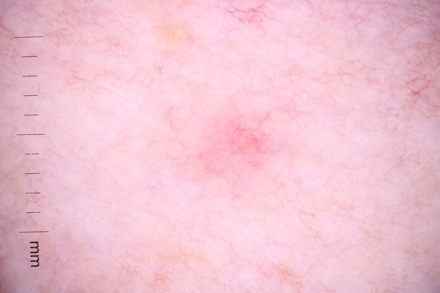

In [60]:
image_path = Path(path/'ISIC/benign/ISIC_0090279.jpg')
img= Image.open(image_path)
print(img.shape)
img.to_thumb(440)

## Malignant Images

In [ ]:
print(os.listdir(path/'ISIC/malignant'))

['ISIC_0149568.jpg', 'ISIC_0188432.jpg', 'ISIC_0207268.jpg', 'skin_img.jpg', 'skin_img2.jpg']


(4000, 6000)


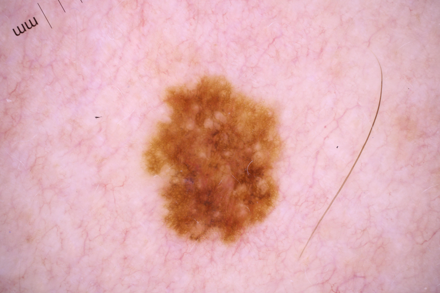

In [56]:
image_path = Path(path/'ISIC/malignant/ISIC_0207268.jpg')
img= Image.open(image_path)
print(img.shape)
img.to_thumb(440)

# Prediction

In [62]:
pred_label, pred_prob = gridsearch_ELT(image_path)
print('Prediction:', pred_label,"; Probability: %0.4f" %pred_prob)

Analyzing ...


Analyzing ...


Analyzing ...


Analyzing ...


Analyzing ...


Analyzing ...


Done!

Prediction: benign ; Probability: 0.6245


In [61]:
pred_label, pred_prob = SVC_ELT(image_path)
print('Prediction:', pred_label,"; Probability: %0.4f" %pred_prob)

Analyzing ...


Analyzing ...


Analyzing ...


Analyzing ...


Analyzing ...


Analyzing ...


Done!

Prediction: benign ; Probability: 0.7715
